In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import folium
import csv

# Recover Ripple Graph

In [2]:
def recover_links_ases(filename):
    links = set()
    ases = set()
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            l = tuple(row)
            links.add(l)
            ases.add(l[0])
            ases.add(l[1])
    return ases,links

In [3]:
ripple_ases, ripple_links = recover_links_ases('Ripple/gateway_links.csv')

In [4]:
ripple_graph = nx.Graph()
ripple_graph.add_nodes_from(ripple_ases)

In [5]:
print('The Ripple graph contains {} nodes'.format(len(ripple_graph.nodes)))

The Ripple graph contains 15 nodes


# Recover Caida Graph

In [6]:
data = pd.read_csv('Caida/20190301.as-rel2.txt',delimiter='\n', comment='#', header=None, encoding='ISO-8859-1')

data['provider_peer'], data['customer_peer'], data['relation_type'], data['source'] = data[0].str.split('|').str
data['relation_type']  = data['relation_type'].apply(lambda x: 'provider-customer' if x == '-1' else 'peer-peer')
links = data[['provider_peer','customer_peer','relation_type']]

caida_ases = set(links['provider_peer'].values)
caida_ases.update(links['customer_peer'].values)

links['link'] = list(zip(links['provider_peer'], links['customer_peer']))
links = links[['link','relation_type']]
caida_links = {}
for index,row in links.iterrows():
    (s,t) = row['link']
    rel = row['relation_type']
    if rel == 'provider-customer':
        caida_links[tuple([s,t])] = rel
        caida_links[tuple([t,s])] = 'customer-provider'
    else: 
        if rel == 'peer-peer':
            caida_links[tuple([s,t])] = rel
            caida_links[tuple([t,s])] = 'peer-peer'
        else:
            print('Error')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [7]:
caida_graph = nx.Graph()
caida_graph.add_nodes_from(caida_ases)
for k,v in caida_links.items():
    caida_graph.add_edge(k[0],k[1])

In [8]:
print('The Caida graph contains {} nodes and {} edges'.format(len(caida_graph.nodes),len(caida_graph.edges)))

The Caida graph contains 64167 nodes and 503651 edges


# Add intermediary nodes to Ripple Graph

In [9]:
def shortest_paths(s,t,G):
    actual_paths = []
    paths = nx.all_shortest_paths(G,s,t)
    for path in paths:
        actual_path = []
        for i in range(len(path)-1):
            l = tuple([path[i],path[i+1]])
            actual_path.append(l)
        actual_paths.append(actual_path)
    return actual_paths

In [10]:
for s in ripple_ases:
    for t in ripple_ases:
        paths = nx.all_shortest_paths(caida_graph,s,t)
        for p in paths:
            complete_path = [s] + p
            for i in range(len(complete_path)-1):
                ripple_graph.add_edge(complete_path[i],complete_path[i+1])

In [11]:
print('The Ripple graph contains {} nodes and {} edges'.format(len(ripple_graph.nodes),len(ripple_graph.edges)))

The Ripple graph contains 324 nodes and 1299 edges


In [12]:
nx.set_edge_attributes(ripple_graph, 0, 'weight')

# Replay transactions 

In [13]:
transactions = pd.read_csv('Ripple/transactions_processed.csv', dtype={'sender': str, 'receiver': str, 'amount': np.float64} )
transactions = transactions[['sender','receiver','amount']]

In [14]:
def replay_transactions_remove(transactions, corrupted_graph, complete_graph):
    amount_ok = 0
    amount_lost = 0
    amount_rerouted = 0
    for index, row in transactions.iterrows():
        sender = row['sender']
        receiver = row['receiver']

        try :
            amount = row['amount']
            ## For the moment, use only the best path
            path_corrupted = nx.shortest_path(corrupted_graph,sender,receiver)
            path_ok = nx.shortest_path(complete_graph,sender,receiver)
            if (path_corrupted == path_ok):
                amount_ok += amount
            else:
                amount_rerouted += amount
        except:
            #print('No path between {} and {}'.format(sender,receiver))
            amount_lost += amount
    return amount_ok, amount_lost, amount_rerouted

In [16]:
print('Amount of money used in the graph : {}'.format(transactions['amount'].sum()))

Amount of money used in the graph : 95369733.78500085


# Graph Statistics

## Are the gateways directly connected?

In [17]:
for g in ripple_ases:
    neighbors = ripple_graph.neighbors(g)
    for n in neighbors:
        if n in ripple_ases and n != g:
            print('There is a link between {} and {}'.format(n,g))

There is a link between 4766 and 26496
There is a link between 13335 and 45102
There is a link between 19551 and 45102
There is a link between 45102 and 13335
There is a link between 19551 and 13335
There is a link between 26496 and 4766
There is a link between 14618 and 16509
There is a link between 16509 and 14618
There is a link between 45102 and 19551
There is a link between 13335 and 19551


/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


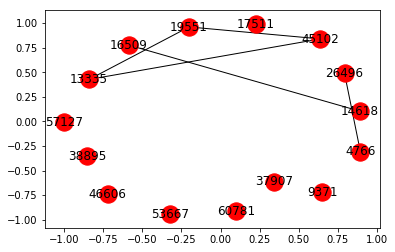

In [18]:
sub = ripple_graph.subgraph(ripple_ases)
nx.draw_networkx(sub)

## How many transactions are affected by a 'direct connection'?

In [19]:
count = 0
amount = 0
for index, row in transactions.iterrows():
    sender = row['sender']
    receiver = row['receiver']
    path = nx.shortest_path(ripple_graph, source=sender, target=receiver)
    if (len(path) == 2):
        count += 1
        amount += row['amount']
        
print('# Transactions affected : {} out of {} - {:.0%}'.format(count, len(transactions), count/len(transactions)))
print('Amount affected : {} out of {} - {:.0%}'.format(amount, transactions['amount'].sum(), amount/transactions['amount'].sum()))

# Transactions affected : 6314 out of 22994 - 27%
Amount affected : 80443866.41520707 out of 95369733.78499946 - 84%


As we can see, only 16% of the total amount can be rerouted since there is no intermediary node

# What if we remove one node?

In [20]:
df_corrupted = pd.DataFrame(columns=['corrupted', 'amount_ok', 'amount_lost', 'amount_rerouted'])

In [21]:
#for c in ripple_graph.nodes:
#    corrupted_graph = ripple_graph.copy()
#    corrupted_graph.remove_node(c)
#    amount_ok, amount_lost, amount_rerouted = replay_transactions_remove(transactions, corrupted_graph, ripple_graph)
#    df_corrupted = df_corrupted.append({'corrupted': c, 'amount_ok': amount_ok, 'amount_lost': amount_lost, 'amount_rerouted': amount_rerouted}, ignore_index=True)

In [23]:
#df_corrupted.set_index('corrupted').to_csv('statistics_remove.csv')

In [29]:
df_corrupted = pd.read_csv('statistics_remove.csv', index_col='corrupted')

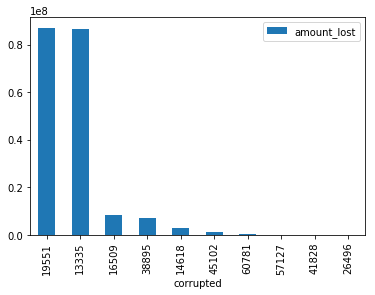

In [38]:
df_corrupted['amount_lost'].sort_values(ascending=False).head(10).to_frame().plot.bar()

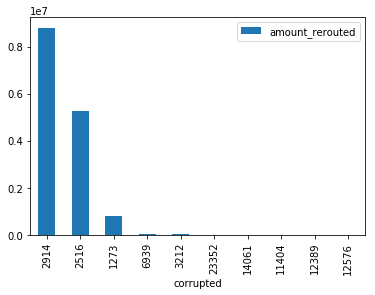

In [39]:
df_corrupted['amount_rerouted'].sort_values(ascending=False).head(10).to_frame().plot.bar()

# What if there is BGP hijacking?